# Time Series Regression for Predicting Clothing and Footwear CPI

Consumer Price Index, CPI, is a measure of weighted average prices for a basket of consumer goods and services. Clothing and Footwear CPI indicates the average variation in the prices of clothing and footwear products and services that a typical consumer pays for. It is also used with other price indices for calculating the change in inflation value. 
 
In this assignment, time series analysis of monthly CPI value for clothing and footwear will be examined. After, the forecasting model will be built. Monthly unemployment rate, average buying USDTRY rate, and the results of a survey about expectation of monthly CPI value for the current month will be used as regressors. Survey results and unemployment rate are given as percentage values. 
 
   Data is accessed on 5th March 2021 and it is installed as an excel file from Electronic Data Delivery System of Republic of Turkey(EVDS). Date range used for this study is from January 2014 to March 2021 in monthly manner. The last observation of unemployment rate was missing on EVDS, therefore, it is accessed from TUIK* website and manually added to the excel file. 
   
EVDS : https://evds2.tcmb.gov.tr/ 
 
TUIK* :https://data.tuik.gov.tr/Bulten/Index?p=Isgucu-Istatistikleri-Ocak-2021-37486#:~:text=Mevsim%20etkisinden%20ar%C4%B1nd%C4%B1r%C4%B1lmam%C4%B1%C5%9F%20i%C5%9Fsizlik%20oran%C4%B1%20bir%20%C3%B6nceki%20y%C4%B1l%C4%B1n%20ayn%C4%B1%20ay%C4%B1na,azalarak%20%13%2C4%20oldu


## Required Packages & Data Preparation

In [1]:
options(warn=-1) #hiding the warning messages
library(data.table)
library(ggplot2)
library(GGally)
library(zoo)
library(lubridate)
library(forecast)
library(readxl)

Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2

Attaching package: 'zoo'

The following objects are masked from 'package:base':

    as.Date, as.Date.numeric


Attaching package: 'lubridate'

The following objects are masked from 'package:data.table':

    hour, isoweek, mday, minute, month, quarter, second, wday, week,
    yday, year

The following objects are masked from 'package:base':

    date, intersect, setdiff, union

Registered S3 method overwritten by 'xts':
  method     from
  as.zoo.xts zoo 
Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


In [2]:
dt <- readxl::read_excel("HW2_dataEVDS.xlsx")
colnames(dt) <- c("Date", "UnempRate", "USDTRY", "CPI", "ExpectRate")
dt <- data.table(dt)
dt <- dt[, Date:=as.Date(as.yearmon(dt$Date))]

str(dt)
head(dt)

Classes 'data.table' and 'data.frame':	87 obs. of  5 variables:
 $ Date      : Date, format: "2014-01-01" "2014-02-01" ...
 $ UnempRate : num  10.5 10.5 9.4 8.8 8.4 9 9.7 10.1 10.1 10.9 ...
 $ USDTRY    : num  2.22 2.21 2.22 2.13 2.09 ...
 $ CPI       : num  149 142 145 164 179 ...
 $ ExpectRate: num  1.06 0.69 0.66 0.76 0.64 0.22 0.06 0.15 0.53 1.38 ...
 - attr(*, ".internal.selfref")=<externalptr> 


Date,UnempRate,USDTRY,CPI,ExpectRate
2014-01-01,10.5,2.216836,149.16,1.06
2014-02-01,10.5,2.212760,141.61,0.69
2014-03-01,9.4,2.217795,145.13,0.66
2014-04-01,8.8,2.127471,164.14,0.76
2014-05-01,8.4,2.090805,179.22,0.64
2014-06-01,9.0,2.115724,176.98,0.22


* Unemployment rate is related to the income per household. When it increases, income per household will decrease, which makes people tend to spend less money. Because clothing and footwear are not essential to survive, CPI is affected by this change. 
 
* USDTRY rate affects every production sectors that use imported products. Therefore, any change in the price of raw materials due to the currency leads to the prices of clothing and footwear goods. 
 
* ExpectRate is the result of a survey about people's expectation on CPI for the next month. People are asked for their expectation on CPI, and the expected change rate is reported as ExpectRate. It can be helpful for forecasting the real CPI for clothing and footwear. 

In [3]:
summary(dt[, 2:5])

   UnempRate         USDTRY           CPI          ExpectRate    
 Min.   : 8.40   Min.   :2.091   Min.   :141.6   Min.   :0.0600  
 1st Qu.:10.20   1st Qu.:2.882   1st Qu.:178.8   1st Qu.:0.5700  
 Median :11.00   Median :3.666   Median :203.5   Median :0.7600  
 Mean   :11.48   Mean   :4.264   Mean   :209.6   Mean   :0.8163  
 3rd Qu.:12.90   3rd Qu.:5.734   3rd Qu.:236.6   3rd Qu.:1.0800  
 Max.   :15.10   Max.   :8.003   Max.   :273.2   Max.   :2.1300  

`geom_smooth()` using method = 'loess' and formula 'y ~ x'


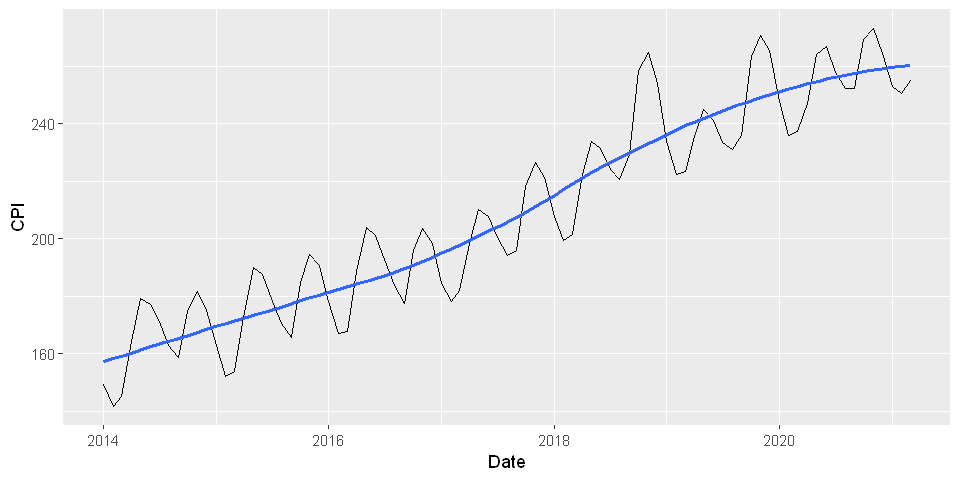

In [4]:
options(repr.plot.width = 8, repr.plot.height = 4) #for scaling the graph
ggplot(dt, aes(x=Date, y=CPI)) + geom_line() + geom_smooth(se=FALSE)

By looking at the smoothed curve (blue one), it can be said that there is an increasing trend. Also, quarterly seasonality could be observed. It seems that the data does not have much noise. Outliers data points does not exist. At the end of 2018 and 2019, there are jumping points. 

## Adding Linear Trend Component

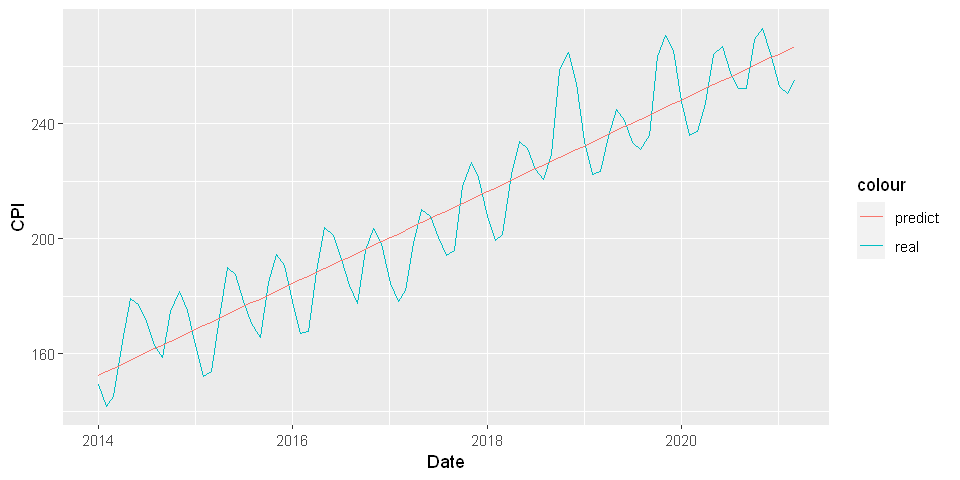

In [5]:
dt <- dt[, trend:=1:.N]
ts_reg <- lm(CPI~trend, data=dt)

dt <- dt[, predictions:=predict(ts_reg, dt)]
ggplot(dt, aes(x=Date)) + geom_line(aes(y=CPI, color="real")) + geom_line(aes(y=predictions, color="predict"))

## Adding Monthly Seasonality Component


Call:
lm(formula = CPI ~ trend + months, data = dt)

Residuals:
     Min       1Q   Median       3Q      Max 
-11.7255  -4.6814  -0.2344   3.1421  19.0970 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 151.65563    1.45659 104.117  < 2e-16 ***
trend         1.32656    0.02877  46.114  < 2e-16 ***
months.L     22.74570    2.47070   9.206 6.79e-14 ***
months.Q     -1.14016    2.49136  -0.458  0.64855    
months.C      7.08215    2.48899   2.845  0.00573 ** 
months^4      7.13904    2.47907   2.880  0.00520 ** 
months^5    -25.79873    2.48943 -10.363 4.66e-16 ***
months^6     -6.36121    2.49399  -2.551  0.01282 *  
months^7      7.63400    2.48630   3.070  0.00299 ** 
months^8      1.42274    2.49302   0.571  0.56994    
months^9      3.45992    2.51454   1.376  0.17298    
months^10     3.22336    2.53070   1.274  0.20675    
months^11     0.23169    2.53605   0.091  0.92745    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Resi

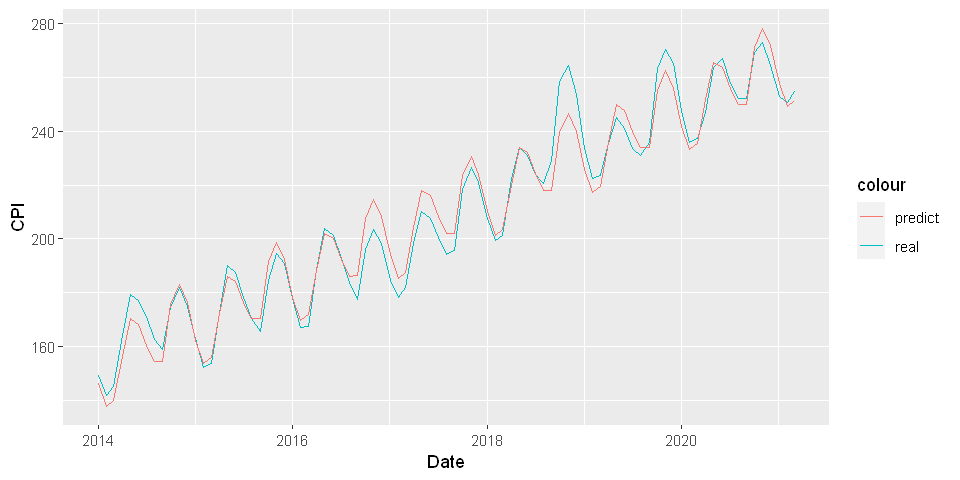

In [6]:
dt <- dt[, months:=lubridate::month(Date, label=TRUE)]
ts_reg <- lm(CPI~trend+months, data=dt)
summary(ts_reg)

dt[, predictions:=predict(ts_reg, dt)]
ggplot(dt, aes(x=Date)) + geom_line(aes(y=CPI, color="real")) + geom_line(aes(y=predictions, color="predict"))

By adding trend and seasonality components, the Adjusted R-Squared value is gotten as 0.9651. The model's p value is very small, which makes the model meaningful. By looking at the graph, it is clear that the model has already predicted well. Now, let's check the residuals and then the regressors will be added to the model. 

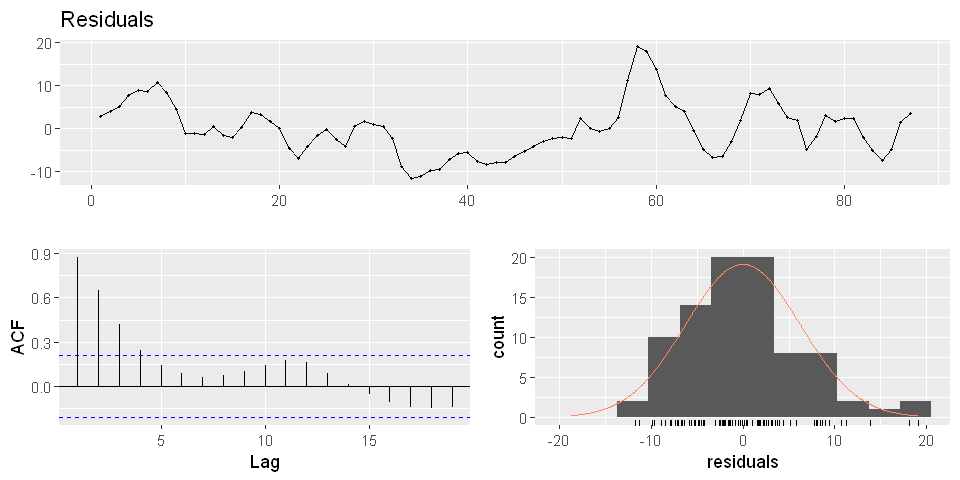

In [7]:
checkresiduals(ts_reg$residuals)

The residuals have zero mean and they are like normally distributed. On the first graph, there are unexplained residuals that can be exploit. Also, there is high correlation at the level of lag=1, which can lead to increase in errors in the future data. 

## Adding Other Regressors to the Model

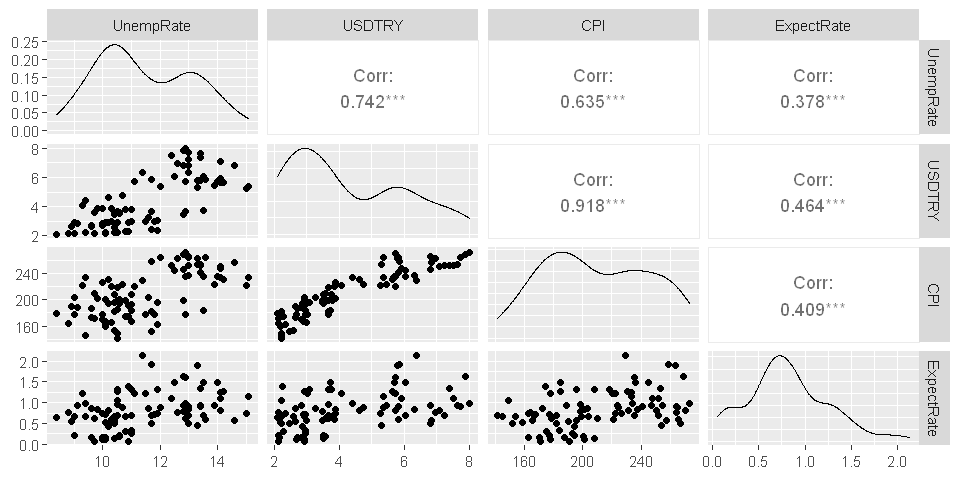

In [8]:
GGally::ggpairs(dt[,2:5])

CPI is significantly correlated with other regressors. There is a linear relationship between CPI and USDTRY. Plus, CPI has a positive relationship with UnempRate. It seems that there is also a weak positive relationship between CPI and ExpectRate. 
 
In order to forecast future, we need lagged observations of regressors. Therefore, cross-corelation between regressors and CPI will be examined below.

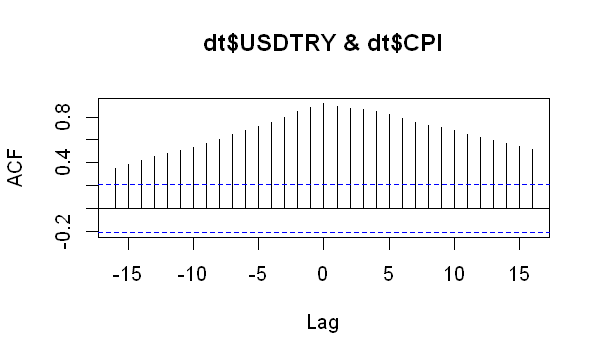

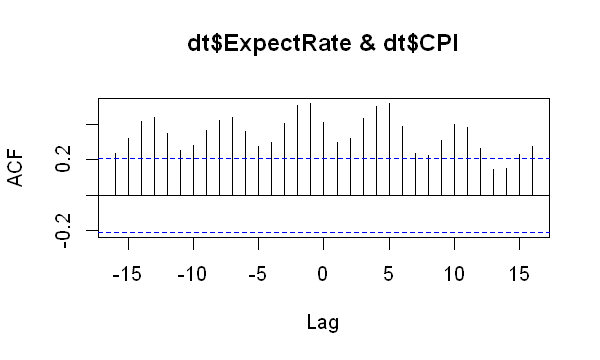

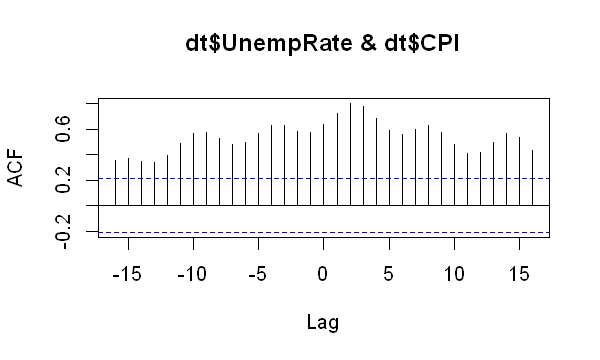

In [9]:
options(repr.plot.width = 5, repr.plot.height = 3) #for scaling the graphs

ccf(dt$USDTRY, dt$CPI)
ccf(dt$ExpectRate, dt$CPI)
ccf(dt$UnempRate, dt$CPI)

We look for negative lag values because of catching the correlations with lagged observations. The highest correlation occurs lag=1 for USDTRY, lag=-1 for ExpectRate, and lag=3 for UnempRate.

### Adding Lagged USDTRY


Call:
lm(formula = CPI ~ trend + months + shift(USDTRY, 1), data = dt)

Residuals:
    Min      1Q  Median      3Q     Max 
-13.397  -4.573  -0.025   3.197  15.050 

Coefficients:
                  Estimate Std. Error t value Pr(>|t|)    
(Intercept)      144.84686    2.26822  63.859  < 2e-16 ***
trend              0.98005    0.09801  10.000 2.96e-15 ***
months.L          22.26599    2.32736   9.567 1.85e-14 ***
months.Q          -1.69407    2.35609  -0.719 0.474456    
months.C           7.49932    2.34316   3.201 0.002042 ** 
months^4           7.42256    2.32264   3.196 0.002072 ** 
months^5         -25.30017    2.32146 -10.898  < 2e-16 ***
months^6          -6.09657    2.31931  -2.629 0.010473 *  
months^7           6.97365    2.31565   3.012 0.003584 ** 
months^8           1.23501    2.31363   0.534 0.595127    
months^9           3.61518    2.33315   1.549 0.125650    
months^10          3.40622    2.34827   1.451 0.151256    
months^11          0.22295    2.35268   0.095 0.9247

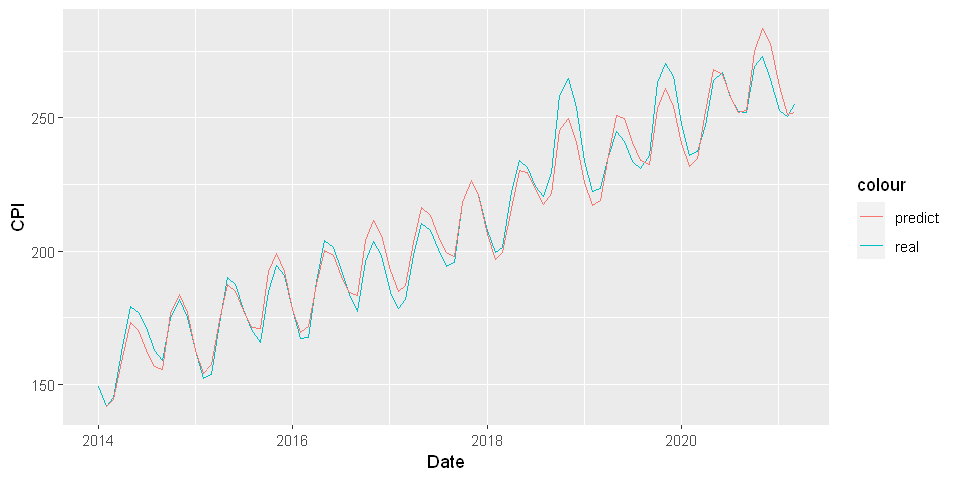

In [10]:
options(repr.plot.width = 8, repr.plot.height = 4) #for scaling the graph

ts_reg <- lm(CPI~trend+months+shift(USDTRY, 1), data=dt)
summary(ts_reg)

dt[, predictions:=predict(ts_reg, dt)]
ggplot(dt, aes(x=Date)) + geom_line(aes(y=CPI, color="real")) + geom_line(aes(y=predictions, color="predict"))

Adjusted R-squared is increased from 0.9651 to 0.9693. Yet, the jumping points in 2019 and 2020 are still not explained.

### Adding Lagged ExpectRate


Call:
lm(formula = CPI ~ trend + months + shift(USDTRY, 1) + shift(ExpectRate, 
    3), data = dt)

Residuals:
     Min       1Q   Median       3Q      Max 
-12.2873  -3.3508   0.7205   3.0362   9.9970 

Coefficients:
                      Estimate Std. Error t value Pr(>|t|)    
(Intercept)          139.96943    2.09826  66.708  < 2e-16 ***
trend                  0.93509    0.08865  10.548 4.94e-16 ***
months.L              28.04670    2.24165  12.512  < 2e-16 ***
months.Q              -5.72242    2.11796  -2.702 0.008671 ** 
months.C               7.56802    1.98723   3.808 0.000300 ***
months^4              -2.11872    2.60752  -0.813 0.419276    
months^5             -23.44693    2.02338 -11.588  < 2e-16 ***
months^6              -7.65526    2.00320  -3.822 0.000287 ***
months^7               9.89783    2.05510   4.816 8.35e-06 ***
months^8               2.35558    1.99690   1.180 0.242204    
months^9              -2.65459    2.27672  -1.166 0.247640    
months^10              6.

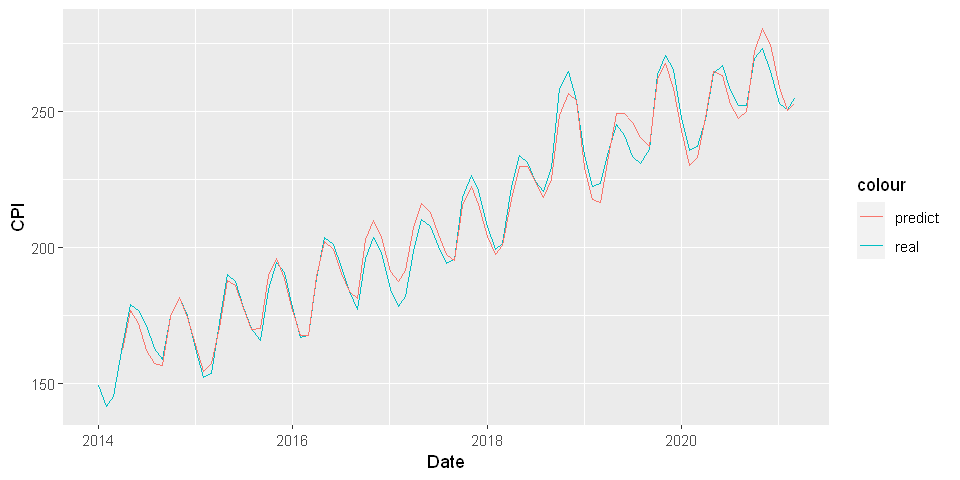

In [11]:
ts_reg <- lm(CPI~trend+months+shift(USDTRY,1)+shift(ExpectRate,3), data=dt)
summary(ts_reg)

dt[, predictions:=predict(ts_reg, dt)]
ggplot(dt, aes(x=Date)) + geom_line(aes(y=CPI, color="real")) + geom_line(aes(y=predictions, color="predict"))

Adjusted R-squared is increased from 0.9693 to 0.9767. Both lagged USDTRY and ExpectRate are significant according to the t test. Jumping points are predicted closely. 

### Adding Lagged UnempRate


Call:
lm(formula = CPI ~ trend + months + shift(USDTRY, 1) + shift(ExpectRate, 
    1) + shift(UnempRate, 3), data = dt)

Residuals:
     Min       1Q   Median       3Q      Max 
-14.4748  -3.6305  -0.4399   2.9583  13.9061 

Coefficients:
                     Estimate Std. Error t value Pr(>|t|)    
(Intercept)          157.4098     7.0090  22.458  < 2e-16 ***
trend                  1.0244     0.1037   9.881 8.89e-15 ***
months.L              19.9025     2.4691   8.061 1.70e-11 ***
months.Q              -2.4235     2.3741  -1.021  0.31097    
months.C               8.4055     2.6296   3.196  0.00211 ** 
months^4               9.4291     2.7751   3.398  0.00114 ** 
months^5             -25.0959     2.8294  -8.870 5.80e-13 ***
months^6              -2.1590     2.7898  -0.774  0.44168    
months^7               6.2623     2.4553   2.551  0.01301 *  
months^8               2.4750     2.4215   1.022  0.31036    
months^9               4.0383     2.2988   1.757  0.08347 .  
months^10      

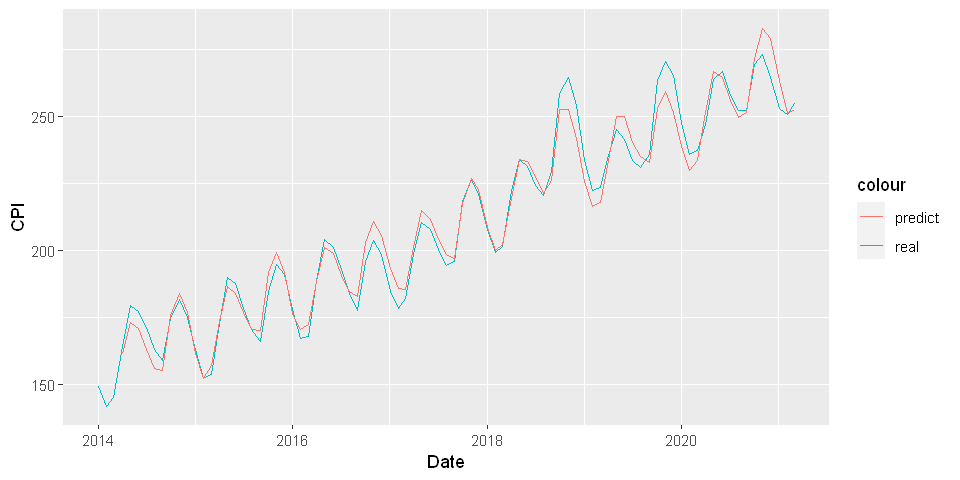

In [12]:
ts_reg <- lm(CPI~trend+months+shift(USDTRY,1)+shift(ExpectRate,1)+shift(UnempRate,3), data=dt)
summary(ts_reg)

dt[, predictions:=predict(ts_reg, dt)]
ggplot(dt, aes(x=Date)) + geom_line(aes(y=CPI, color="real")) + geom_line(aes(y=predictions, color="predict"))

Adjusted R-squared is decreased from 0.9767 to 0.9689. After the year 2019, the predictions become worse. Also, the significance of ExpectRate is decreased and UnempRate does not have a high significance level. Therefore, UnempRate will not be used while building the model. Let's check the residuals again.

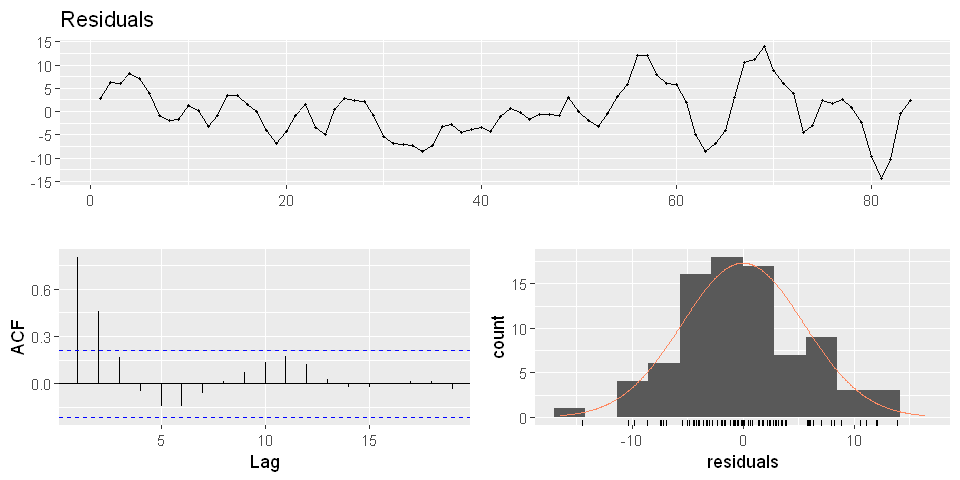

In [13]:
checkresiduals(ts_reg$residuals)

The residuals have a mean value close to zero and they are like normally distributed. On the first graph, it can be seen that errors are increasing with time. The reason may be the correlation of residuals with their 1 lagged values. Therefore, I will use one lagged CPI observations as regressors and check the result.

## Adding Lagged CPI Values to the Model


Call:
lm(formula = CPI ~ trend + months + shift(USDTRY, 1) + shift(ExpectRate, 
    1) + shift(CPI, 1), data = dt)

Residuals:
    Min      1Q  Median      3Q     Max 
-6.5206 -1.6478 -0.0461  1.8207  5.9082 

Coefficients:
                      Estimate Std. Error t value Pr(>|t|)    
(Intercept)           21.13262    7.94364   2.660 0.009672 ** 
trend                  0.13236    0.07179   1.844 0.069475 .  
months.L              10.06522    1.33436   7.543 1.27e-10 ***
months.Q             -11.72954    1.27904  -9.171 1.29e-13 ***
months.C               7.60059    1.16232   6.539 8.55e-09 ***
months^4             -13.35507    2.01283  -6.635 5.74e-09 ***
months^5             -18.57926    1.27886 -14.528  < 2e-16 ***
months^6              10.88220    1.59045   6.842 2.42e-09 ***
months^7               6.87201    1.15100   5.970 8.83e-08 ***
months^8               2.54535    1.14320   2.227 0.029200 *  
months^9               7.36841    1.12154   6.570 7.53e-09 ***
months^10          

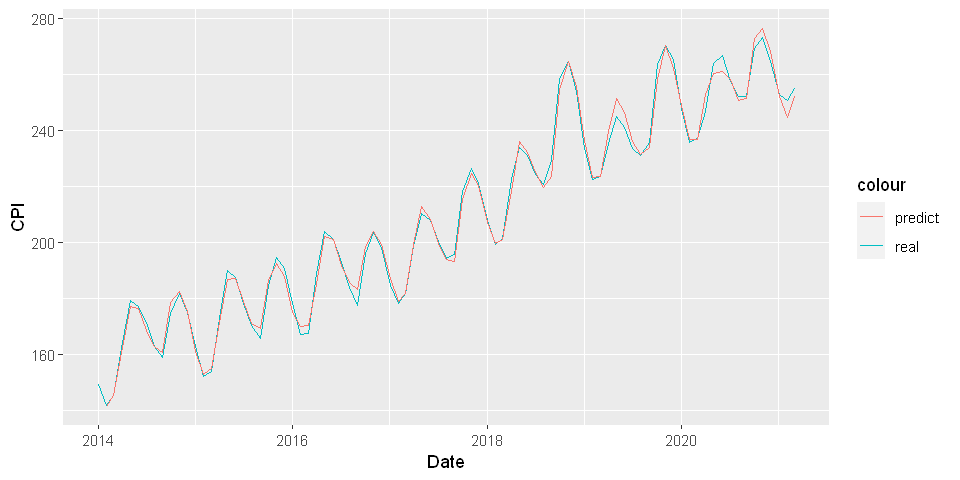

In [14]:
ts_reg <- lm(CPI~trend+months+shift(USDTRY,1)+shift(ExpectRate,1)+shift(CPI,1), data=dt)
summary(ts_reg)

dt[, predictions:=predict(ts_reg, dt)]
ggplot(dt, aes(x=Date)) + geom_line(aes(y=CPI, color="real")) + geom_line(aes(y=predictions, color="predict"))

Now, the end of year 2018 and 2019 are forecasted more accurately. Adjusted R-Squared value is rised to 0.9932. Lagged ExpectRate and lagged CPI are very significant for the model but the significance of USDTRY is lost. The p value of f-statistics is very low, whick makes the model meaningful. Before forecasting the april value of CPI with the model, let's check the predictions versus real CPI graph in order to see if the x=y line occurs.

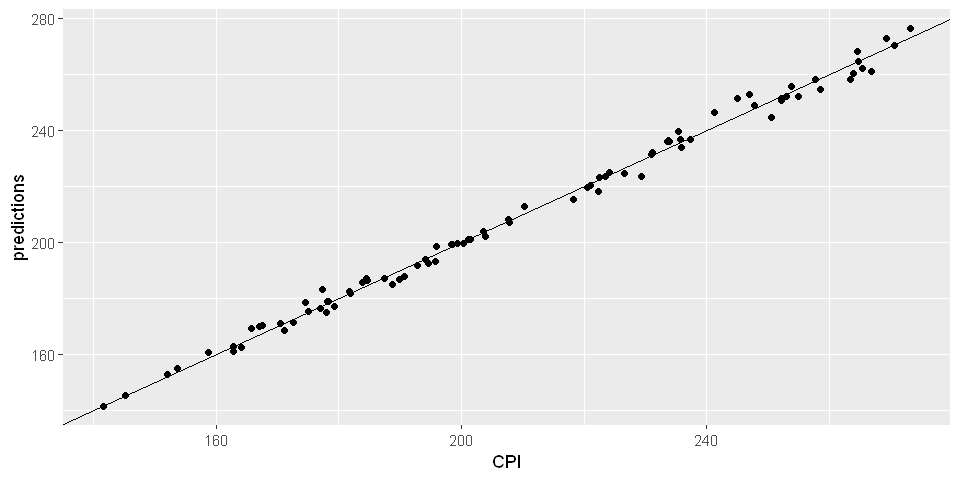

In [15]:
ggplot(dt, aes(x=CPI, y=predictions)) + geom_point() + geom_abline(intercept=0, slope=1)

It is very close to x=y line. Then, let's predict the next month value!

## Forecast for April 2021 & Conclusion

In this assignment, the aim was building a time series model and forecasting the next month's value of Clothing and Footwear CPI. In order to forecast future values of  CPI, the model uses: 
* trend component
* monthly seasonality component
* one month lagged USDTRY
* one month lagged ExpectRate
* one month lagged CPI value 
 
The coefficients are shown below. The model has an adjusted R-squared value of 0.9932. While building this model, we started with adding trend and seasonality components. After, we added one month lagged USDTRY, ExpectRate, and UnempRate as regressors. Since lagged UnempRate did not make the model better, we eliminated it. Then, we made residual analysis and realized that using one month lagged CPI values as regressor may make the model better. We added it and got the final model. 

In [16]:
ts_reg


Call:
lm(formula = CPI ~ trend + months + shift(USDTRY, 1) + shift(ExpectRate, 
    1) + shift(CPI, 1), data = dt)

Coefficients:
         (Intercept)                 trend              months.L  
             21.1326                0.1324               10.0652  
            months.Q              months.C              months^4  
            -11.7295                7.6006              -13.3551  
            months^5              months^6              months^7  
            -18.5793               10.8822                6.8720  
            months^8              months^9             months^10  
              2.5454                7.3684                3.0742  
           months^11      shift(USDTRY, 1)  shift(ExpectRate, 1)  
             -0.4894                0.5926                4.9386  
       shift(CPI, 1)  
              0.8462  


In [17]:
#adding new row with NA values for April 2021 and making prediction of the CPI value
aprilRow <- data.table(Date=as.Date("2021-04-01"), UnempRate=NA, USDTRY=NA, CPI=NA, ExpectRate=NA, 
                     trend=dim(dt)[1]+1, predictions=NA, months=month(as.Date("2021-04-01"), label=TRUE))
dt <- rbind(dt, aprilRow)
dt <- dt[, predictions:=predict(ts_reg, dt)]
tail(dt)

Date,UnempRate,USDTRY,CPI,ExpectRate,trend,predictions,months
2020-11-01,12.9,8.003324,273.24,0.99,83,276.6474,Nov
2020-12-01,13.0,7.721065,264.54,0.90,84,268.2004,Dec
2021-01-01,13.4,7.393975,252.97,1.35,85,252.3342,Jan
2021-02-01,14.1,7.072365,250.63,0.81,86,244.7578,Feb
2021-03-01,13.4,7.628235,254.93,0.93,87,252.0513,Mar
2021-04-01,NA,NA,NA,NA,88,270.7925,Apr


The Clothing and Footwear CPI forecast for April 2021 is 270.7925. 

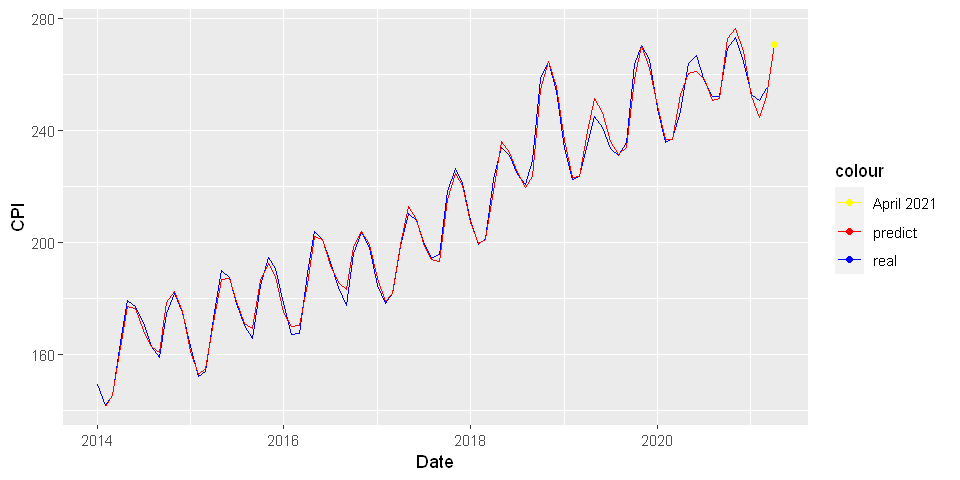

In [18]:
ggplot(dt, aes(x=Date)) + geom_line(aes(y=CPI, 
    color="real")) + geom_line(aes(y=predictions, color="predict")) + geom_point(aes(x=dt[.N, Date], 
    y=dt[.N, predictions], color="April 2021")) + scale_color_manual(values=c("yellow", "red", "blue"))